# Using Bayesdawn's imputation feature on a simple example

## 0. Import relevant modules

In [1]:
from bayesdawn import datamodel, psdmodel
import numpy as np
import random
import time
from scipy import signal
from matplotlib import pyplot as plt

## 1. Generate example data

In [2]:
# Choose size of data
n_data = 2**14
# Set sampling frequency
fs = 1.0
# Generate Gaussian white noise
noise = np.random.normal(loc=0.0, scale=1.0, size = n_data)
# Apply filtering to turn it into colored noise
r = 0.01
b, a = signal.butter(3, 0.1/0.5, btype='high', analog=False)
n = signal.lfilter(b,a, noise, axis=-1, zi=None) + noise*r

t = np.arange(0, n_data) / fs
f0 = 1e-2
a0 = 5e-3
s = a0 * np.sin(2 * np.pi * f0 * t)

mask = np.ones(n_data)
n_gaps = 30
gapstarts = (n_data * np.random.random(n_gaps)).astype(int)
gaplength = 10
gapends = (gapstarts+gaplength).astype(int)
for k in range(n_gaps): mask[gapstarts[k]:gapends[k]]= 0

y = s + n
y_masked = mask * y

## 2. Define your PSD function and embed it in a class

In [3]:
def psd_function(freq):
    """
    Your PSD function.

    Parameters
    ----------
    freq : ndarray
        Vector of frequency values in Hz.

    Returns
    -------
    psd : ndarray
        Vector of one-sided PSD values computed at freq, expressed in A^2 / Hz, where
        A is the physical unit of the considered time series quantity. 

    """
    w, h = signal.freqz(b, a, worN=freq, plot=None, fs=fs)
    return 2 * (np.abs(h)**2 + np.abs(r)**2)

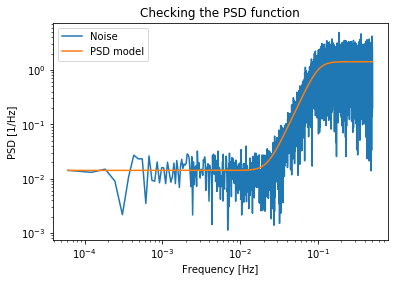

In [4]:
# Check that the PSD function is consistent with the data
f = np.fft.fftfreq(n_data) * fs
n_fft = np.fft.fft(n)
psd = psd_function(f[f>0])
# Plot data against PSD
fig, ax = plt.subplots()
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD [1/Hz]") 
ax.loglog(f[f>0], np.abs(n_fft[f>0]) * np.sqrt(2 / (n_data*fs)), label="Noise")
ax.loglog(f[f>0], np.sqrt(psd), label="PSD model")
plt.legend()
plt.show()

In [5]:
# Embedd the PSD function in a class
class MyPSD(psdmodel.PSD):

    def __init__(self, n_data, fs):

        psdmodel.PSD.__init__(self, n_data, fs, fmin=None, fmax=None)

    def psd_fn(self, x):

        return psd_function(x)

In [6]:
# Instantiate the psd class
psd_cls = MyPSD(n_data, fs)

## 3. Instantiate the imputation class

In [7]:
# instantiate imputation class
imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='nearest', na=50, nb=50)
# imp_cls = datamodel.GaussianStationaryProcess(s, mask, psd_cls, method='woodbury', na=50, nb=50)
# perform offline computations
imp_cls.compute_offline()
# If you want to update the deterministic signal (the mean of the Gaussian process)
imp_cls.update_mean(s)
# If you want to update the PSD model
imp_cls.update_psd(psd_cls)

Computation of autocovariance + PSD took 0.004918098449707031


## 4. Perform missing data imputation

In [8]:
# Imputation of missing data by randomly drawing from their conditional distribution
t1 = time.time()
y_rec = imp_cls.impute(y_masked, draw=True)
t2 = time.time()
print("Missing data imputation took " + str(t2-t1))
# Fourier transform the results and the input data
y_fft = np.fft.fft(y)
y_masked_fft = np.fft.fft(y_masked)
y_rec_fft = np.fft.fft(y_rec)

Missing data imputation took 0.10784101486206055


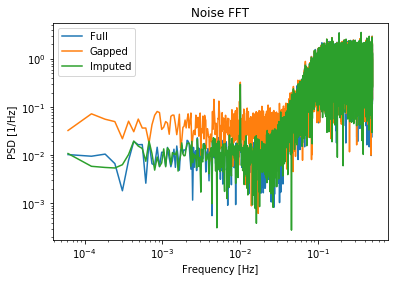

In [9]:
# Plot results
fig, ax = plt.subplots()
ax.set_title(r"Noise FFT")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD [1/Hz]") 
ax.loglog(f[f>0], np.abs(y_fft[f>0])/np.sqrt(n_data*fs), label="Full")
ax.loglog(f[f>0], np.abs(y_masked_fft[f>0])/np.sqrt(n_data*fs), label="Gapped")
ax.loglog(f[f>0], np.abs(y_rec_fft[f>0])/np.sqrt(n_data*fs), label="Imputed")
plt.legend()
plt.show()